In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import itertools
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import numpy as np
import pandas as pd
import requests
import seaborn as sns

import covid19

## data

In [3]:
data_italy_regions_path = 'dpc-covid19-ita-regioni.csv'
# data_italy_regions_path = covid19.data.download('regioni')


In [4]:
df_italy_regions = pd.read_csv(data_italy_regions_path, parse_dates=['data'], index_col=['data'])

df_italy_regions.index = df_italy_regions.index.normalize()

REGIONS = df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)['denominazione_regione'].tolist()

print(REGIONS)

data_italy_regions = {region: df_italy_regions[df_italy_regions['denominazione_regione'] == region] for region in REGIONS}
for dr in data_italy_regions.values():
    dr['deceduti_attuali'] = dr['deceduti'].diff(1)

df_italy_regions.loc[df_italy_regions.index.max()].sort_values('ricoverati_con_sintomi', ascending=False)[['denominazione_regione', 'ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti']]


['Lombardia', 'Emilia Romagna', 'Piemonte', 'Veneto', 'Toscana', 'Liguria', 'Lazio', 'Marche', 'Puglia', 'Campania', 'Sicilia', 'P.A. Trento', 'Abruzzo', 'Friuli Venezia Giulia', 'P.A. Bolzano', 'Umbria', 'Calabria', 'Sardegna', "Valle d'Aosta", 'Basilicata', 'Molise']


,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,deceduti
data,,,,
2020-03-29,Lombardia,11613,1328,6360
2020-03-29,Emilia Romagna,3769,333,1443
2020-03-29,Piemonte,2985,443,684
2020-03-29,Veneto,1586,355,392
2020-03-29,Toscana,1111,275,215
2020-03-29,Liguria,1077,166,377
2020-03-29,Lazio,1062,133,136
2020-03-29,Marche,1000,168,386
2020-03-29,Puglia,559,99,86


In [5]:
DAY = np.timedelta64(24 * 60 * 60, 's')
PALETTE_ONE = list(sns.color_palette())


EXTENT = ('2020-02-20', '2020-03-30')
XLIM = tuple(map(np.datetime64, EXTENT))

In [6]:
REGIONS_FIT_PARAMS = {
    'Lombardia': {
        'ricoverati_con_sintomi': ['2020-03-06', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
    'Emilia Romagna': {
        'ricoverati_con_sintomi': ['2020-03-06', '2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
    'Piemonte': {
        'ricoverati_con_sintomi': ['2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
    'Veneto': {
        'ricoverati_con_sintomi': ['2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
    'Marche': {
        'ricoverati_con_sintomi': ['2020-03-15'],
        'terapia_intensiva': 0,
        'deceduti': ['2020-03-20', '2020-03-25'],
    },
    'Lazio': {
        'ricoverati_con_sintomi': ['2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
    'Friuli Venezia Giulia': {
        'ricoverati_con_sintomi': ['2020-03-19'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
    'Umbria': {
        'ricoverati_con_sintomi': ['2020-03-21'],
        'terapia_intensiva': 0,
        'deceduti': 5,
    },
}

In [7]:
region_fits = {}
for region, params in REGIONS_FIT_PARAMS.items():
    region_fits[region] = {}
    for kind, limits in params.items():
        region_fits[region][kind] = []
        if isinstance(limits, int):
            limits = [np.datetime64(d) + limits * DAY for d in params['ricoverati_con_sintomi']]
        starts = [None] + list(map(np.datetime64, limits))
        stops = [d - DAY for d in starts[1:]] + [None]
        for start, stop in zip(starts, stops):
            try:
                region_fits[region][kind] += [covid19.fit.ExponentialFit.from_frame(kind, data_italy_regions[region], start=start, stop=stop)]
            except:
                print('skipping:', region, start, stop)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


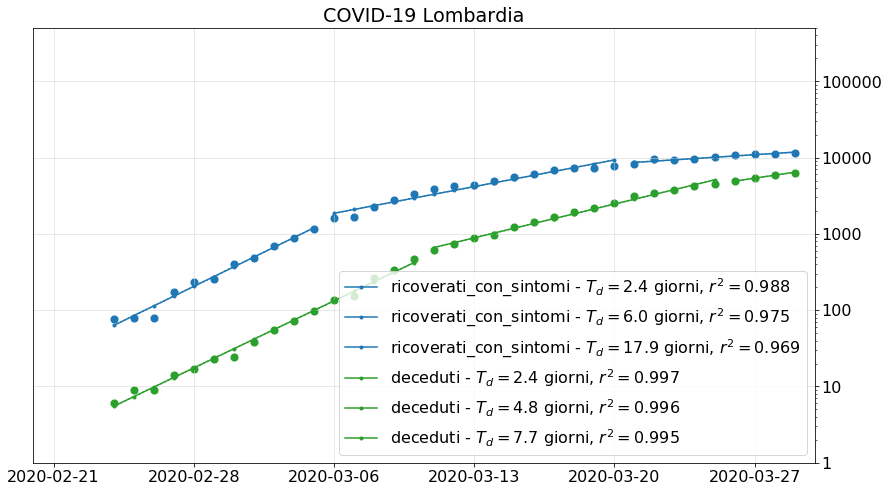

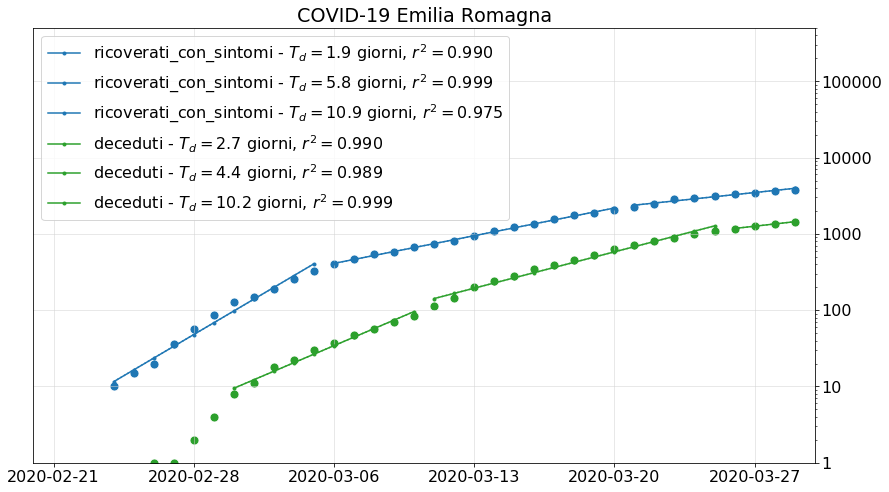

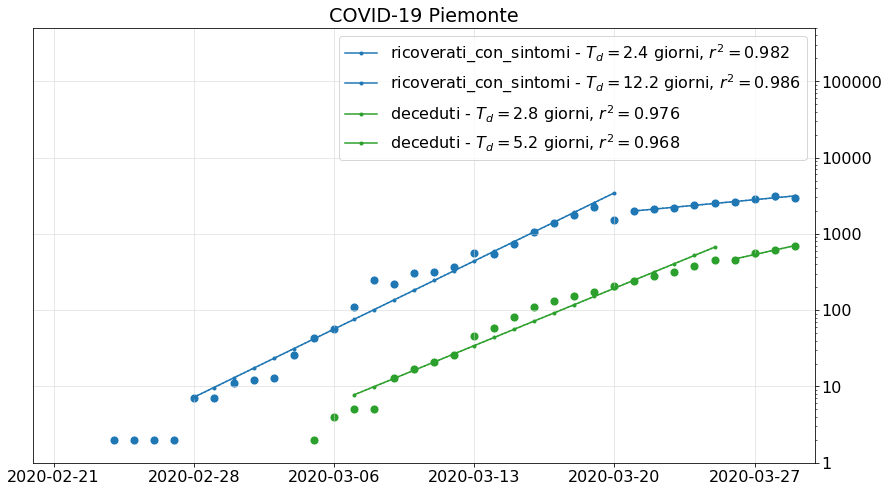

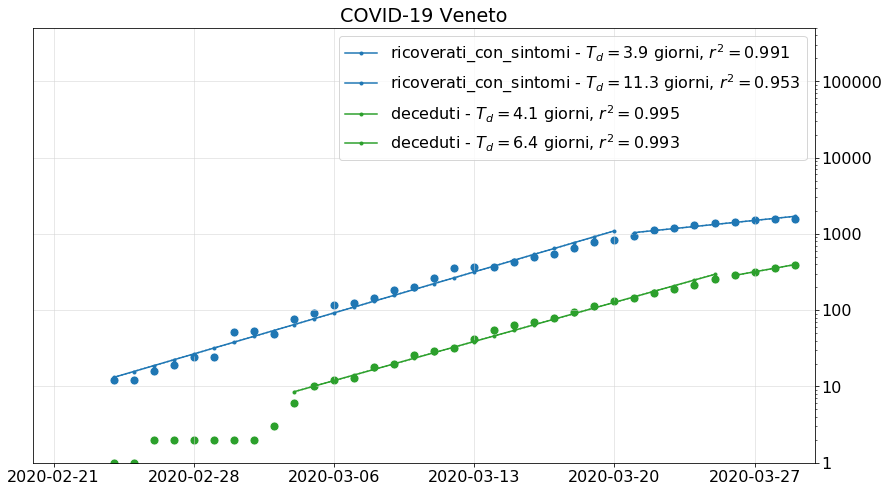

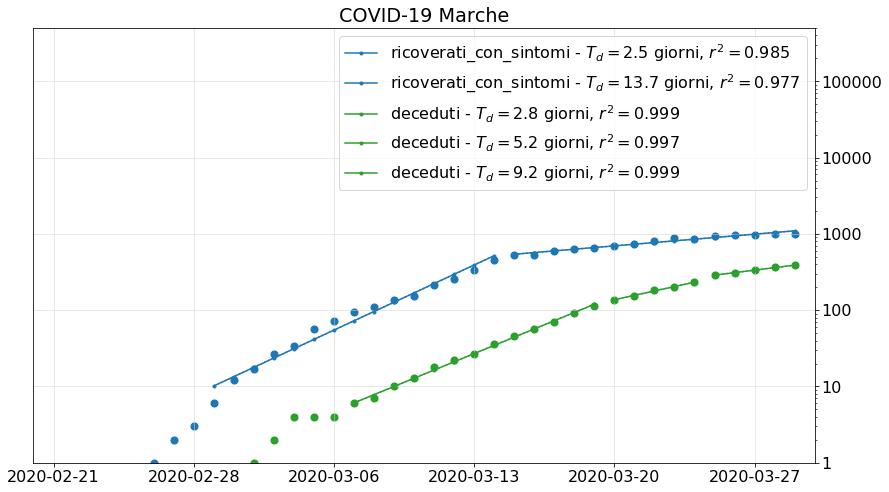

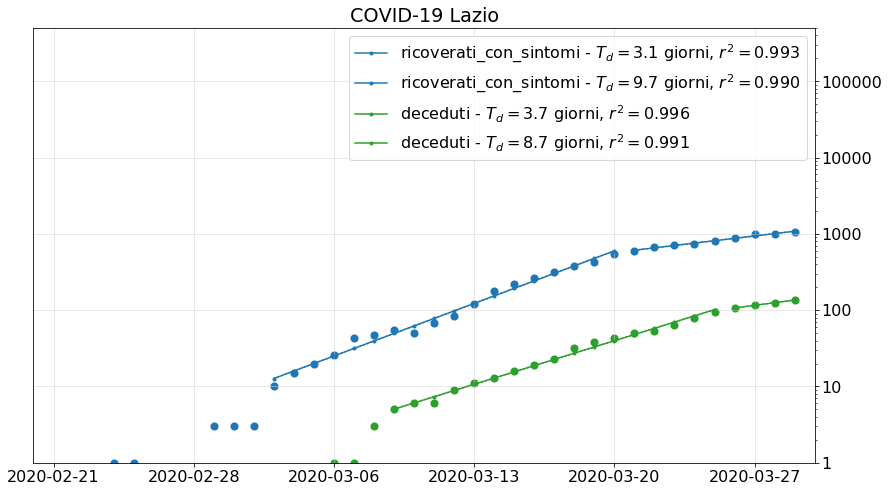

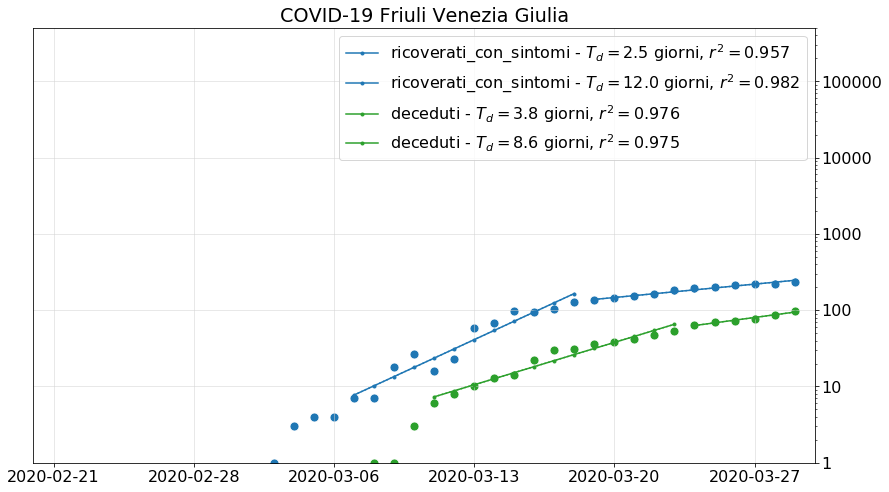

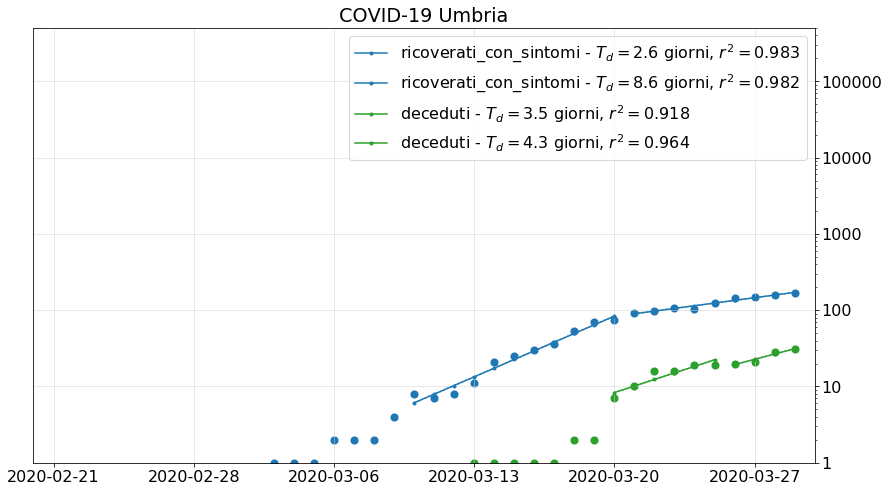

In [8]:
for region, fit_kinds in region_fits.items():
    _, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (1, 500000), 'xlim': XLIM}, figsize=(14, 8))
    ax.yaxis.grid(color='lightgrey', linewidth=0.5)
    ax.xaxis.grid(color='lightgrey', linewidth=0.5)
    ax.set_title(f'COVID-19 {region}')
    ax.yaxis.tick_right()
    ax.legend(loc='top left')

    for (kind, fits), color in zip(fit_kinds.items(), PALETTE_ONE):
        if kind == 'terapia_intensiva':
            continue
        for fit in fits:
            covid19.plot.plot_fit(ax, fit, label=kind, color=color)

        covid19.plot.plot_data(ax, data_italy_regions[region][kind], color=color, date_interval=7)